In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
iris = datasets.load_iris()

In [3]:
data=pd.DataFrame(iris.data,columns=['feature1','feature2','feature3','feature4'])
target=pd.DataFrame(iris.target)
#traget=target.rename(columns={"0":"target"})
train=pd.concat([data,target],axis=1)
train

,feature1,feature2,feature3,feature4,0
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
train_set=train[(train[0] ==0) |(train[0] == 1)]

In [5]:
train_set.drop(['feature3','feature4'],axis=1,inplace=True)

D:\anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
train_set

,feature1,feature2,0
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
95,5.7,3.0,1
96,5.7,2.9,1
97,6.2,2.9,1
98,5.1,2.5,1


In [7]:
set0=train_set[train_set[0]==0]
train_x1=np.array(train_set['feature1'])
train_x1=train_x1.reshape(-1,1)
train_x2=np.array(train_set['feature2'])
train_x2=train_x2.reshape(-1,1)
train_x=np.c_[train_x1,train_x2]
train_y=np.array(train_set[0]).reshape(-1,1)
adaboost=0
alpha_set=np.zeros([10000,1])
lr_dict={}

# other methods
from sklearn.svm import SVC 
svm=SVC(C=1, kernel='linear')
svm.fit(train_x,train_y)
svm.score(train_x,train_y)
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth=1)
tree.fit(train_x,train_y)
tree.score(train_x,train_y)
tree.predict(train_x)

In [8]:
from sklearn.linear_model import LogisticRegression

new_weight=np.ones(train_set[0].shape)/len(train_set[0])
new_weight=new_weight.reshape(-1,1)*100
new_weight=new_weight.reshape(-1,)
lr_dict[0]=LogisticRegression(C=0.005,solver='liblinear',class_weight={0:1,1:1})
lr_dict[0].fit(train_x,train_y,sample_weight=new_weight)
lr_dict[0].score(train_x,train_y,sample_weight=new_weight)

In [9]:

def plot_decision_boundary(pred_func,train_set,X):
    set0=train_set[train_set[0]==0]
    x0_1=np.array(set0['feature1'])
    x0_1=x0_1.reshape(-1,1)
    x0_2=np.array(set0['feature2'])
    x0_2=x0_2.reshape(-1,1)
    set1=train_set[train_set[0]==1]
    x1_1=np.array(set1['feature1'])
    x1_1=x1_1.reshape(-1,1)
    x1_2=np.array(set1['feature2'])
    x1_2=x1_2.reshape(-1,1)
    
    # set max and min, add a 0.5 margin
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # using contouf to plot decision boundary
    plt.contourf(xx, yy, Z)
    plt.scatter(x0_1, x0_2,marker="o",label='category 1')
    plt.scatter(x1_1, x1_2,marker="v",label='category 2')
    plt.legend()

In [10]:
#plot_decision_boundary(lambda x: lr_dict[0].predict(x),train_set,train_x)

In [11]:
def learner_weight(minError):
    alpha = 1/2 * (math.log((1-minError)/minError))
    return alpha

In [12]:
def error_calculation1(predict,true):
    right=sum((predict==true)*1)/len(true)
    error=1-right
    return error

In [13]:
def error_calculation(lr_dict,p,train_x,train_y,new_weight):
    error=1-lr_dict[p].score(train_x,train_y,sample_weight=new_weight)
    return error

In [14]:
def new_sample_weight(alpha,weight, train_set, prediction):
    sumWeight = 0
    for i in range(len(train_set[0])):
        if train_set[0][i] != prediction[i]:
            flag=1
            weight[i] = weight[i]*math.exp(alpha*flag)
        else:
            flag=-1
            weight[i] = weight[i]*math.exp(alpha*flag)
        sumWeight += weight[i]
    for i in range(len(train_set[0])):
        weight[i] = weight[i] / sumWeight
 
    return weight

error=error_calculation1(lr_dict[0].predict(train_x).reshape(-1,1),train_y)
alpha=learner_weight(error)
alpha_set[0]=alpha
adaboost+=alpha*lr_dict[0].predict(train_x)
prediction=lr_dict[0].predict(train_x)
new_weight=new_sample_weight(alpha,weight, train_set, prediction)

new_weight=new_weight.reshape(-1,)
lr_dict[1]=LogisticRegression(C=1)
lr_dict[1].fit(train_x,train_y,sample_weight=new_weight)

lr_dict[1].score(train_x,train_y,sample_weight=new_weight)

In [15]:
#error=error_calculation(lr_dict[1].predict(train_x).reshape(-1,1),train_y)
#alpha=learner_weight(error)
#alpha_set[1]=alpha
#adaboost+=alpha*lr_dict[1].predict(train_x)
#prediction=lr_dict[1].predict(train_x)
#new_weight=new_sample_weight(alpha,weight, train_set, prediction)

In [16]:
def ensemble(x,i,lr_dict,alpha_set):
    prediction=0
    for k in range(i):
        prediction=prediction+(alpha_set[k]/sum(alpha_set))*(lr_dict[k].predict(x))
    for m in range(prediction.shape[0]):
        if prediction[m]>=0.5:
            prediction[m]=1
        else:
            prediction[m]=0
    return prediction

In [17]:
def plot_decision_boundary1(pred_func,train_set,X,i,lr_dict,alpha_set):
    set0=train_set[train_set[0]==0]
    x0_1=np.array(set0['feature1'])
    x0_1=x0_1.reshape(-1,1)
    x0_2=np.array(set0['feature2'])
    x0_2=x0_2.reshape(-1,1)
    set1=train_set[train_set[0]==1]
    x1_1=np.array(set1['feature1'])
    x1_1=x1_1.reshape(-1,1)
    x1_2=np.array(set1['feature2'])
    x1_2=x1_2.reshape(-1,1)
    
    # set max and min, add a 0.5 margin
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()],i,lr_dict,alpha_set)
    Z = Z.reshape(xx.shape)
    # using contouf to plot decision boundary
    plt.contourf(xx, yy, Z)
    plt.scatter(x0_1, x0_2,marker="o",label='category 1')
    plt.scatter(x1_1, x1_2,marker="v",label='category 2')
    plt.legend()

0.81
0.6913580246913582
0.5789473684210528
0.56
0.5988837209302322
0.5341880341880344
0.6811753225587177
0.9777815548377565
0.5000000000000003
0.4999999999999998
0.5
0.49999999999999983
0.5000000000000001
0.5000000000000001
0.49999999999999983


<Figure size 432x288 with 0 Axes>

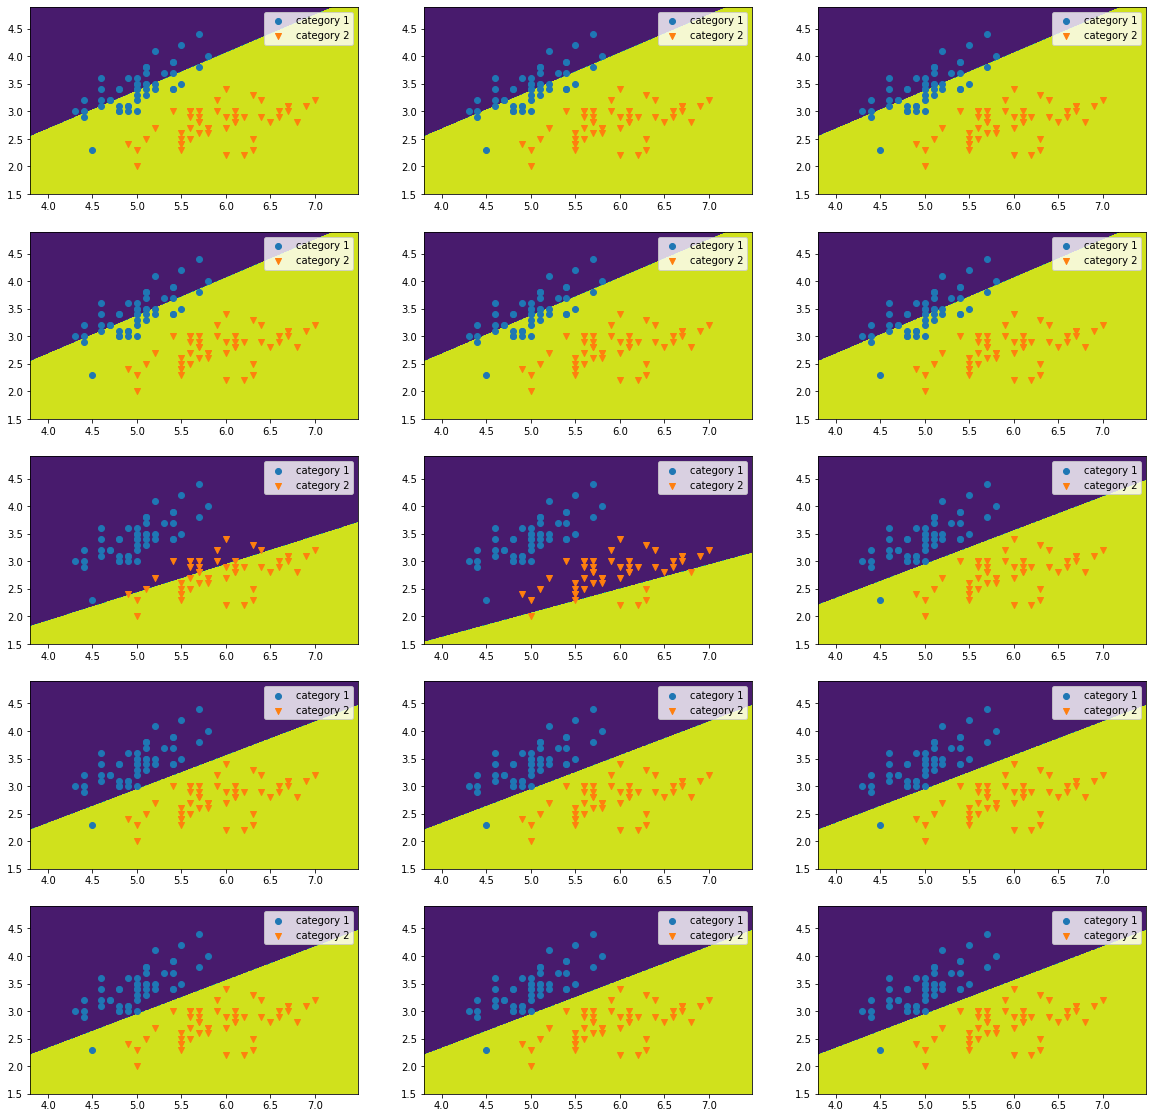

In [18]:
plt.subplots_adjust(hspace=15,wspace=0.8)
plt.figure(figsize=(20,20))
for p in range(30):
    if p == 0:
        new_weight=np.ones(train_set[0].shape)/len(train_set[0])
        new_weight=new_weight.reshape(-1,1)*100
        new_weight=new_weight.reshape(-1,)
        plt.subplot(5,3,1)
        lr_dict[p]=LogisticRegression(C=0.005,solver='liblinear',class_weight={0:1,1:1})
        lr_dict[p].fit(train_x,train_y.reshape(-1,),sample_weight=new_weight)
        print(lr_dict[p].score(train_x,train_y,sample_weight=new_weight))
        #lr_dict[p].score(train_x,train_y)
        plot_decision_boundary(lambda x: lr_dict[p].predict(x),train_set,train_x)
        error=error_calculation(lr_dict,p,train_x,train_y,new_weight)
        alpha=learner_weight(error)
        alpha_set[p]=alpha
        #adaboost+=alpha*lr_dict[p].predict(train_x)
        prediction=lr_dict[p].predict(train_x)
        new_weight=new_sample_weight(alpha,new_weight, train_set, prediction)*100
    elif (((p+1)%2==0) and p<28) :
        plt.subplot(5,3,((p+1)/2)+1)
        new_weight=new_weight.reshape(-1,)
        lr_dict[p]=LogisticRegression(C=0.005,solver='liblinear',class_weight={0:1,1:1})
        lr_dict[p].fit(train_x,train_y.reshape(-1,),sample_weight=new_weight)
        print(lr_dict[p].score(train_x,train_y,sample_weight=new_weight))
        error=error_calculation(lr_dict,p,train_x,train_y,new_weight)
        alpha=learner_weight(error)
        alpha_set[p]=alpha
        #adaboost+=alpha*lr_dict[1].predict(train_x)
        prediction=lr_dict[p].predict(train_x)
        new_weight=new_weight.reshape(-1,1)
        new_weight=new_sample_weight(alpha,new_weight, train_set, prediction)*100
        plot_decision_boundary1(ensemble,train_set,train_x,p,lr_dict,alpha_set)
    else:
        new_weight=new_weight.reshape(-1,)
        lr_dict[p]=LogisticRegression(C=0.005,solver='liblinear',class_weight={0:1,1:1})
        lr_dict[p].fit(train_x,train_y.reshape(-1,),sample_weight=new_weight)
        #print(lr_dict[p].score(train_x,train_y,sample_weight=new_weight))
        error=error_calculation(lr_dict,p,train_x,train_y,new_weight)
        #error=error_calculation(lr_dict[p].predict(train_x).reshape(-1,1),train_y)
        alpha=learner_weight(error)
        alpha_set[p]=alpha
        #adaboost+=alpha*lr_dict[1].predict(train_x)
        prediction=lr_dict[p].predict(train_x)
        new_weight=new_weight.reshape(-1,1)
        new_weight=new_sample_weight(alpha,new_weight, train_set, prediction)*100

In [19]:
alpha_set[0:15]

array([[0.72500509],
       [0.40323793],
       [0.18974481],
       [0.15922687],
       [0.13721842],
       [0.12058103],
       [0.09724415],
       [0.20040805],
       [0.09158795],
       [0.06848293],
       [0.80825893],
       [0.37958919],
       [0.03384751],
       [1.89218174],
       [0.55649711]])

In [20]:
ensemble

<function __main__.ensemble(x, i, lr_dict, alpha_set)>